In [1]:
# import DMeRates
import DMeRates.DMeRate as DMeRate
import torch
import numericalunits as nu
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True  # Enable LaTeX
params = {'text.usetex' : True,
            'font.size' : 12,
            'font.family' : 'cmr10',
            'figure.autolayout': True
            }
plt.rcParams.update(params)
plt.rcParams['axes.unicode_minus']=False
plt.rcParams['axes.labelsize']=10

In [2]:
FDMn = 2

halo_model = 'shm'
DoScreen = False
test_mX = 10. #MeV
test_mX_eV = test_mX*1e6
test_mX_unitized= test_mX * nu.MeV / nu.c0**2
ne = 1
cs = 1e-36
cs_unitized = cs * nu.cm**2
nes = [1,2,3,4,5,6,7,8,9,10]
mX_array = np.concatenate((np.arange(0.2,0.8,0.025),np.array([0.9]),np.arange(1,5,0.05),np.arange(5,11,1),np.array([20,50,100,200,500,1000,10000]))) #MeV


In [3]:
from QCDark.dark_matter_rates import d_rate,default_screening,default_si,read_output,default_astro
default_astro['sigma_e'] = cs

from QCDark.dark_matter_rates import form_factor as qcdark_form_factor



if DoScreen:
    screening = default_si
else:
    screening = default_screening
cff = read_output('QCDark/results/Si_final.hdf5')
Ee_old, dR_old= d_rate(test_mX_eV, cff, FDM_exp = FDMn, screening = screening, astro_model = default_astro)

from QEDark.QEDark2 import QEDark
qedark = QEDark()

Ee_qe = np.arange(0,50,0.1)
drde_qedark = qedark.vectorized_dRdE('Si',test_mX_eV,Ee_qe,FDMn,'imb',DoScreen=DoScreen)


import DMeRates
import DMeRates.DMeRate
dmrates_qedark = DMeRate.DMeRate('Si',QEDark=True)
dmrates = DMeRate.DMeRate('Si',QEDark=False)
dmrates.update_crosssection(cs)
dmrates_qedark.update_crosssection(cs)



dmrates_qedark.setup_halo_data(test_mX,FDMn,'shm')
dmrates.setup_halo_data(test_mX,FDMn,'shm')

# drde_qcdark_redo_res = dmrates.vectorized_dRdE(test_mX,FDMn,halo_model,DoScreen=DoScreen,integrate=True,unitize=True,debug=True) 
drde_qedark_redo = dmrates_qedark.vectorized_dRdE(test_mX,FDMn,'imb',DoScreen=DoScreen,integrate=False,unitize=True,debug=False).cpu().numpy()
drde_qcdark_redo_res = dmrates.vectorized_dRdE(test_mX,FDMn,'shm',DoScreen=DoScreen,integrate=True,unitize=True,debug=True) 
dmrates.setup_halo_data(test_mX,FDMn,'modulated',isoangle=35,useVerne=True)
drde_qcdark_redo_mod_res = dmrates.vectorized_dRdE(test_mX,FDMn,'modulated',DoScreen=DoScreen,integrate=True,unitize=True,debug=True) 
drde_qcdark_redo_mod = drde_qcdark_redo_mod_res['drde'].cpu().numpy()
drde_qcdark_redo = drde_qcdark_redo_res['drde'].cpu().numpy()
Earr = dmrates.Earr.cpu().numpy()
Earr /= nu.eV

Earr_qedark = dmrates_qedark.Earr.cpu().numpy()
Earr_qedark /= nu.eV

CUDA/MPS GPU not found, performing calculations on cpu (if you are doing this on apple silicon you can change your device to mps if you'd like)
CUDA/MPS GPU not found, performing calculations on cpu (if you are doing this on apple silicon you can change your device to mps if you'd like)
Using form factor calculated from file: /Users/ansh/Local/SENSEI/DarkMatterRates/DMeRates/../QCDark/results/Si_final.hdf5


/Users/ansh/.pyenv/versions/3.12.2/lib/python3.12/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/ansh/.pyenv/versions/3.12.2/lib/python3.12/site-packages/torchquad/integration/simpson.py:76: UserWarning: N per dimension cannot be even due to necessary subdivisions. N per dim will now be changed to the next lower integer, i.e. 1250 -> 1249.
  warnings.warn(
/Users/ansh/.pyenv/versions/3.12.2/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **

In [4]:
# from DMeRates.form_factor import form_factorQEDark
# import os
# import torch
# torch.set_default_dtype(torch.float32)

# import numpy as np

# module_dir = '.'

# form_factor_file = f'../QEDark/QEdark-python/Si_f2.txt'



# form_factor_file_filepath = os.path.join(module_dir,form_factor_file)

# ffactor = form_factorQEDark(form_factor_file_filepath)

# nE = np.shape(ffactor.ff)[1]
# nQ = np.shape(ffactor.ff)[0]

# qiArr = torch.arange(1,nQ+1) #for indexing
# qArr = torch.clone(qiArr) * torch.tensor(ffactor.dq)

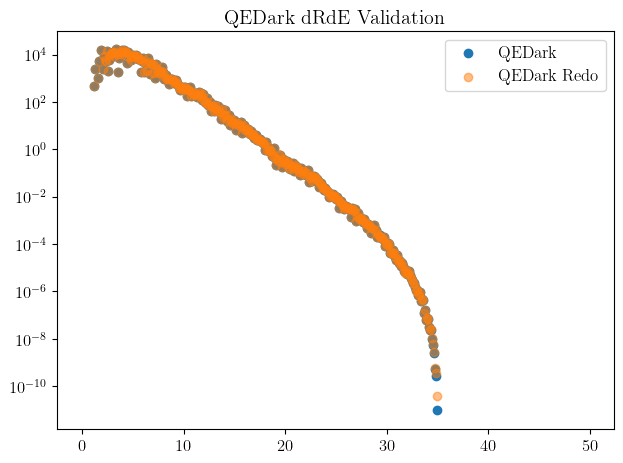

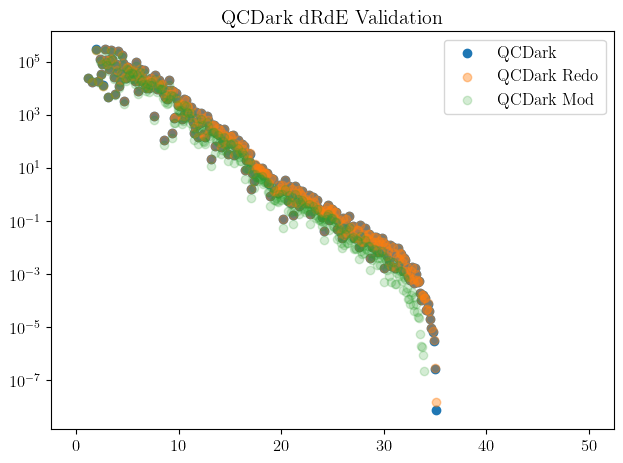

In [5]:


plt.scatter(Earr_qedark,drde_qedark,label='QEDark')
plt.scatter(Earr_qedark,drde_qedark_redo,label='QEDark Redo',alpha=0.5)
plt.yscale('log')
plt.legend()
plt.title('QEDark dRdE Validation')
plt.show()
plt.close()

plt.scatter(Ee_old,dR_old,label='QCDark')
plt.scatter(Earr,drde_qcdark_redo,label='QCDark Redo',alpha=0.4)
plt.scatter(Earr,drde_qcdark_redo_mod,label='QCDark Mod',alpha=0.2)

plt.yscale('log')
plt.legend()
plt.title('QCDark dRdE Validation')
plt.show()
plt.close()




In [5]:
# 

In [6]:
# from QCDark.dark_matter_rates import d_rate_FanoQ,d_rate_RamanathanQ

# ionizationFile = 'DMeRates/p100k.dat'
# ionization_model = 'R'

# Si_ff = qcdark_form_factor('QCDark/results/Si_final.hdf5')
# from QEDark.QEDark2 import QEDark
# qedark = QEDark()
# qedark_step= QEDark()
# qedark_step.change_to_step()

# qcdark_results = []
# qedark_results = []
# qcdark_results_step = []
# qedark_results_step = []

# for mX in mX_array: #MeV
#     qcdarkeresult = d_rate_RamanathanQ(mX*1e6, Si_ff, ionizationFile, FDM_exp = FDMn, screening = screening, astro_model = default_astro)
#     qcdarkeresult = qcdarkeresult[1][ne]
#     qcdark_results.append(qcdarkeresult)

#     qcdarkeresultstep = d_rate_FanoQ(mX*1e6, Si_ff, 3.8, FDM_exp = FDMn, screening = screening, astro_model = default_astro)
#     qcdarkeresultstep = qcdarkeresultstep[1][ne]
#     qcdark_results_step.append(qcdarkeresultstep)


#     qedarkresult = qedark.vectorized_dRdnE('Si',mX,nes,FDMn,'imb',DoScreen=DoScreen)[ne-1]
#     qedark_results.append(float(qedarkresult))
#     qedarkresultstep = qedark_step.vectorized_dRdnE('Si',mX,nes,FDMn,'imb',DoScreen=DoScreen)[ne-1]
#     qedark_results_step.append(float(qedarkresultstep))

# qedark_results = np.array(qedark_results)
# qcdark_results = np.array(qcdark_results)
# qedark_results_step = np.array(qedark_results_step)
# qcdark_results_step = np.array(qcdark_results_step)



In [18]:
import DMeRates
import DMeRates.DMeRate as DMeRate
dmrates = DMeRate.DMeRate('Si',QEDark=False)
dmrates_qedark = DMeRate.DMeRate('Si',QEDark=True)

CUDA GPU found, performing calculations on GPU
Using form factor calculated from file: c:\Users\Ansh\Projects\DarkMatterRates\DMeRates\../QCDark/results/Si_final.hdf5
CUDA GPU found, performing calculations on GPU


In [21]:

import time
start = time.time()
qcdark_redo = dmrates.calculate_rates(mX_array,'shm',FDMn,ne=nes,integrate=True,DoScreen=DoScreen)[ne-1] *nu.kg*nu.year
end = time.time()
print(f"took {end - start}s")
qedark_redo = dmrates_qedark.calculate_rates(mX_array,'imb',FDMn,ne=nes,integrate=False,DoScreen=DoScreen)[ne-1] *nu.kg*nu.year
end2 = time.time()
print(f"took {end2 - end}s")

dmrates_qedark.change_to_step()
dmrates.change_to_step()

qcdark_redo_step = dmrates.calculate_rates(mX_array,'shm',FDMn,ne=nes,integrate=True,DoScreen=DoScreen)[ne-1] *nu.kg*nu.year
qedark_redo_step = dmrates_qedark.calculate_rates(mX_array,'imb',FDMn,ne=nes,integrate=False,DoScreen=DoScreen)[ne-1] *nu.kg*nu.year

qedark_redo_step = qedark_redo_step.cpu()
qcdark_redo_step = qcdark_redo_step.cpu()
qedark_redo = qedark_redo.cpu()
qcdark_redo = qcdark_redo.cpu()

took 0.4487752914428711s
took 0.2410290241241455s


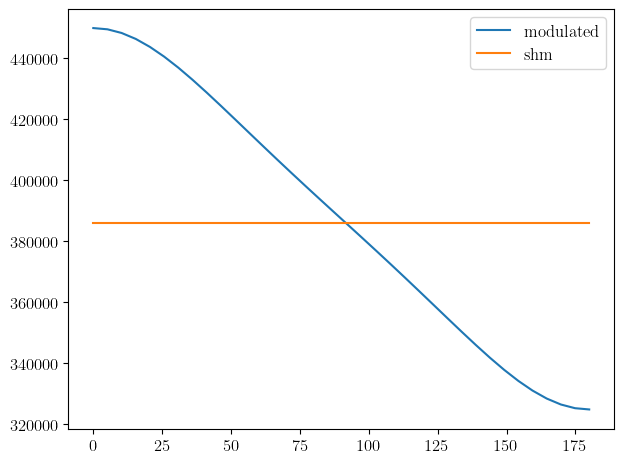

took 0.3870258331298828s


In [23]:
test_mX = 1.
test_cs = 1e-34
dmrates.update_crosssection(test_cs)
FDMn = 2
isoangles = np.linspace(0,180,36)
rate_per_angle = np.zeros(36)
rate_flat = np.zeros(36)
import time
start = time.time()
for isoangle in range(36):
    r = dmrates.calculate_rates(test_mX,'modulated',FDMn,ne=nes,integrate=True,DoScreen=True,isoangle=isoangle,useVerne=True)[ne-1] *nu.kg*nu.year
    rate_per_angle[isoangle] = r.cpu()
    r = dmrates.calculate_rates(test_mX,'shm',FDMn,ne=nes,integrate=True,DoScreen=True,isoangle=None)[ne-1] *nu.kg*nu.year
    rate_flat[isoangle] = r.cpu()
end = time.time()

plt.plot(isoangles,rate_per_angle,label='modulated')
plt.plot(isoangles,rate_flat,label='shm')
plt.legend()
plt.show()
plt.close()
print(f"took {end - start}s")

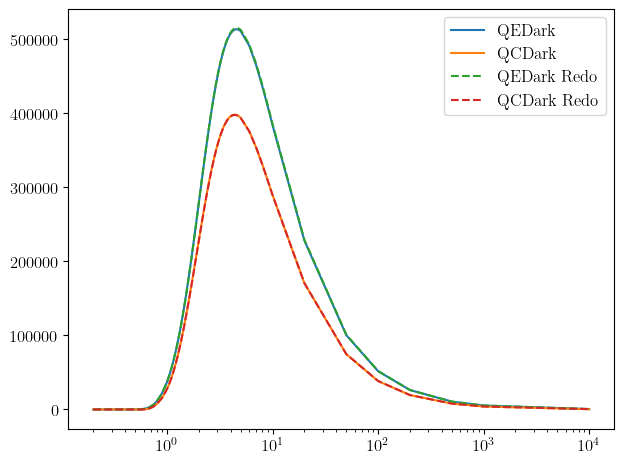

In [9]:
plt.plot(mX_array,qedark_results,label='QEDark')
plt.plot(mX_array,qcdark_results,label='QCDark')
plt.plot(mX_array,qedark_redo,label='QEDark Redo',ls='--')
plt.plot(mX_array,qcdark_redo,label='QCDark Redo',ls='--')

plt.legend()
plt.xscale('log')
# plt.yscale('log')

plt.show()
plt.close()

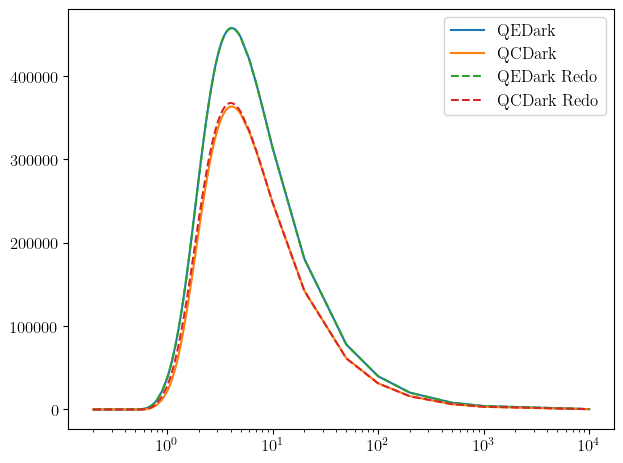

In [10]:
plt.plot(mX_array,qedark_results_step,label='QEDark')
plt.plot(mX_array,qcdark_results_step,label='QCDark')
plt.plot(mX_array,qedark_redo_step,label='QEDark Redo',ls='--')
plt.plot(mX_array,qcdark_redo_step,label='QCDark Redo',ls='--')

plt.legend()
plt.xscale('log')
# plt.yscale('log')

plt.show()
plt.close()

In [1]:
#this is for testing wimprates
import DMeRates
import DMeRates.DMeRate as DMeRate
material = 'Xe'
dmrates = DMeRate.DMeRate(material)
import numpy as np

import numericalunits as nu
from DMeRates.Constants import *


CUDA GPU found, performing calculations on GPU


In [2]:
test_shell = '5p'
test_mX = 1000
test_mX_unitized = test_mX * nu.MeV / nu.c0**2
test_mX_eV = 1000*1e6

test_cs = 1e-34
FDMn = 0
halo_model = 'shm'

dmrates.update_crosssection(test_cs)

dmrates.setup_halo_data(test_mX,FDMn,'shm')

drs = dmrates.noble_dRdE(test_mX,FDMn,halo_model,halo_id_params=None,debug=False,unitize=True)


c:\Users\Ansh\anaconda3\envs\dmerates\Lib\site-packages\torch\__init__.py:1236: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\tensor\python_tensor.cpp:436.)
  _C._set_default_tensor_type(t)
c:\Users\Ansh\anaconda3\envs\dmerates\Lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
dr_5p_res = dmrates.rate_dme_shell(test_mX_unitized,FDMn,halo_model,test_shell,unitize=True,debug=True)

tensor([[0.0000e+00, 1.5270e-17]])
returning debug output:
integrated_result,prefactor,fdm_factor,ff_arr,etas,qArr,qmin,qmax


In [4]:
import sys
sys.path.append('wimprates_mod')
from wimprates_ansh import rate_dme,rate_dme_sum,dRdE,years_per_day,dRdne
erec = dmrates.Earr.cpu().numpy() / nu.eV
drs_old = dRdE(test_mX,test_cs,FDMn,e_er = None,isoangle = None,mat = material,useVerne = True,verbose=False,integrate=False)
# years_per_day


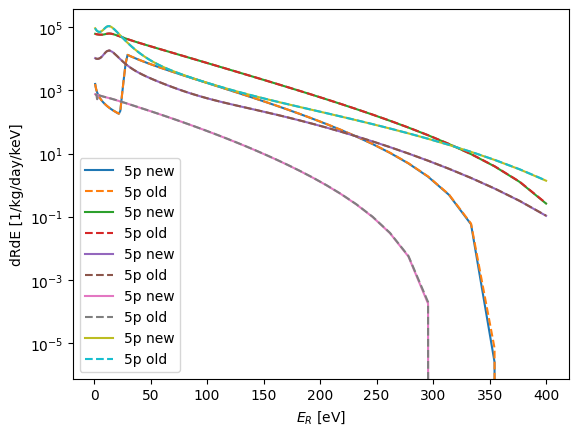

In [5]:
import matplotlib.pyplot as plt
import numericalunits as nu
for shell in dmrates.form_factor.keys:
    if shell in skip_keys[material]:
        continue
    plt.plot(erec,drs[shell].cpu(),label=f"{test_shell} new")
    plt.plot(erec,drs_old[shell]*years_per_day,label=f"{test_shell} old",ls='--')

plt.yscale('log')
plt.xlabel('$E_R$ [eV]')
plt.legend()
plt.ylabel("dRdE [1/kg/day/keV]")
plt.show()
plt.close()


In [6]:
import torch
nes = torch.arange(1,17)
n_el, drsrates_old = dRdne(test_mX,test_cs,FDMn,e_er = None,isoangle=None,material='Xe',maxne = int(torch.max(nes)),ne='All',return_shells=True,useVerne=True,verbose=False,integrate=False)
n_el, drsn_old_sun = dRdne(test_mX,test_cs,FDMn,e_er = None,isoangle=None,material='Xe',maxne = int(torch.max(nes)),ne='All',return_shells=False,useVerne=True,verbose=False,integrate=False)
drsn_old_sun[1]

np.float64(559998606.7200326)

In [7]:
import time
start = time.time()
rates_new_allsum = dmrates.calculate_nobleGas_rates(test_mX,halo_model,FDMn,nes,isoangle=None,halo_id_params=None,useVerne=False,calcErrors=None,debug=False,returnShells=False)

rates_new_all,shells = dmrates.calculate_nobleGas_rates(test_mX,halo_model,FDMn,nes,isoangle=None,halo_id_params=None,useVerne=False,calcErrors=None,debug=False,returnShells=True)
end = time.time()
print(f"took {end-start}s")
shells

took 0.285480260848999s


['Summed', '4p', '4d', '5s', '4s', '5p']

In [8]:
import time
start = time.time()
for isoangle in range(36):
    dmrates.setup_halo_data(test_mX,FDMn,'modulated',isoangle=35,useVerne=True)
    drs = dmrates.noble_dRdE(test_mX,FDMn,'modulated',halo_id_params=None,debug=False,unitize=True)

    rates_new_allsum = dmrates.calculate_nobleGas_rates(test_mX,halo_model,FDMn,nes,isoangle=isoangle,halo_id_params=None,useVerne=True,calcErrors=None,debug=False,returnShells=False)
end = time.time()
print(f"took {end-start}s")

took 1.012620210647583s


<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Ansh\AppData\Local\Temp\ipykernel_50992\744520448.py:4: SyntaxWarning: invalid escape sequence '\c'
  title = f"$m_\chi$ = {test_mX} MeV/c$^2$, $\sigma_e =$ {test_cs} cm$^2$, FDM = {fdm_str}"
C:\Users\Ansh\AppData\Local\Temp\ipykernel_50992\744520448.py:4: SyntaxWarning: invalid escape sequence '\s'
  title = f"$m_\chi$ = {test_mX} MeV/c$^2$, $\sigma_e =$ {test_cs} cm$^2$, FDM = {fdm_str}"


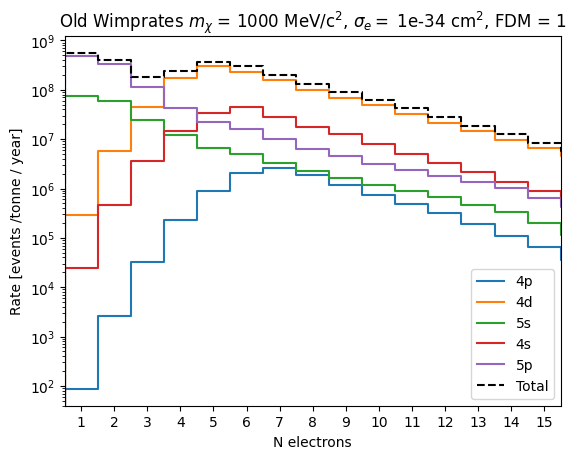

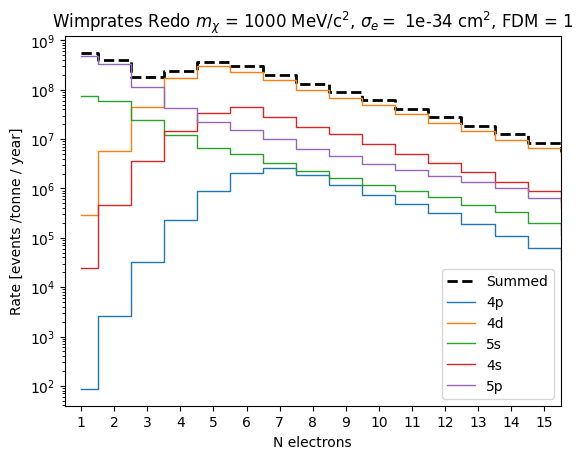

In [9]:
fdm_dict = {0: '1',
            2: '$1/q^2$'}
fdm_str = fdm_dict[FDMn]
title = f"$m_\chi$ = {test_mX} MeV/c$^2$, $\sigma_e =$ {test_cs} cm$^2$, FDM = {fdm_str}" 

plt.title('Old Wimprates '+title)# + (' -- SWAP 4s<->4p' if True else ''))
drsrates_old
for shell, rn in drsrates_old.items():
        plt.plot(n_el, np.array(rn), drawstyle='steps-mid', label=shell)
plt.plot(n_el, np.sum(np.array(list(drsrates_old.values())), axis=0),
            label='Total',
            drawstyle='steps-mid', 
            linestyle='--', 
            c='k')
plt.xticks(np.arange(1, 16))
plt.xlim(0.5, 15.5)
plt.xlabel("N electrons")
plt.legend()
plt.yscale('log')
plt.ylabel(f"Rate [events /tonne / year]")
plt.show()
plt.close()

plt.title('Wimprates Redo ' + title)# + (' -- SWAP 4s<->4p' if True else ''))


for i,key in enumerate(shells):
        ls = '--' if i == 0 else None
        c = 'k' if i ==0 else None
        lw = 2 if i == 0 else 1
        r = rates_new_all[0][:,i] * nu.tonne * nu.year
        r = r.cpu()
        nes = nes.cpu()
        plt.plot(nes,r,drawstyle='steps-mid',label=key,ls=ls,c=c,lw=lw)
plt.xticks(np.arange(1, 16))
plt.xlim(0.5, 15.5)
plt.xlabel("N electrons")
plt.legend()
plt.yscale('log')
plt.ylabel(f"Rate [events /tonne / year]")

plt.show()
plt.close()

In [10]:
import os
from numpy import loadtxt
from torchinterp1d import interp1d
ne = [1,2,3,4,5,6,7,8,9,10]
filepath = os.path.join(dmrates.module_dir,'p100k.dat')
p100data = loadtxt(filepath)
pEV = torch.tensor(p100data[:,0]) *nu.eV
file_probabilities = torch.tensor(p100data.T)#[:,:]
file_probabilities = file_probabilities
print(file_probabilities.shape)
print(pEV.shape)

probabilities = interp1d(pEV, file_probabilities,dmrates.Earr)
probabilities.shape

torch.Size([21, 979])
torch.Size([979])


torch.Size([1, 100])

In [2]:
import DMeRates
import DMeRates.DMeRate as DMeRate
dmrates = DMeRate.DMeRate('Si',QEDark=False)
import numpy as np
dm_masses = np.geomspace(0.5,10,20)
for FDMn in [0,2]:
    dmrates.generate_dat(dm_masses,[1],FDMn,'shm',DoScreen=True,write=True,tag="1e")

CUDA/MPS GPU not found, performing calculations on cpu (if you are doing this on apple silicon you can change your device to mps if you'd like)
Using form factor calculated from file: /Users/ansh/Local/SENSEI/DarkMatterRates/DMeRates/../QCDark/results/Si_final.hdf5


/Users/ansh/Local/SENSEI/DarkMatterRates/DMeRates/DMeRate.py:1011: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/20 [00:00<?, ?it/s]

/Users/ansh/.pyenv/versions/3.12.2/lib/python3.12/site-packages/torch/__init__.py:1236: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:436.)
  _C._set_default_tensor_type(t)
/Users/ansh/.pyenv/versions/3.12.2/lib/python3.12/site-packages/torchquad/integration/simpson.py:76: UserWarning: N per dimension cannot be even due to necessary subdivisions. N per dim will now be changed to the next lower integer, i.e. 1250 -> 1249.
  warnings.warn(
/Users/ansh/.pyenv/versions/3.12.2/lib/python3.12/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, *

  0%|          | 0/20 [00:00<?, ?it/s]